In [105]:
import torch 
import torch.nn as nn 
from torchvision  import datasets
from torchvision import transforms
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('default')

In [2]:
input_shape = 28*28
hidden_size = 256
out_size = 10
epochs = 20
batch_size = 128 
lr = 0.001

In [3]:
training_data = datasets.MNIST(root = "/MNIST_DATA/", 
                              train=True,
                               transform=transforms.ToTensor(),
                               download= True
                              )

testing_data = datasets.MNIST(root= "/MNIST_DATA/",
                             train= False, 
                              transform= transforms.ToTensor(),
                             )

In [4]:
train_loader = torch.utils.data.DataLoader(training_data, 
                                           batch_size= batch_size,
                                           shuffle= True
                                          )
test_loader = torch.utils.data.DataLoader(testing_data, 
                                         batch_size= batch_size,
                                         )

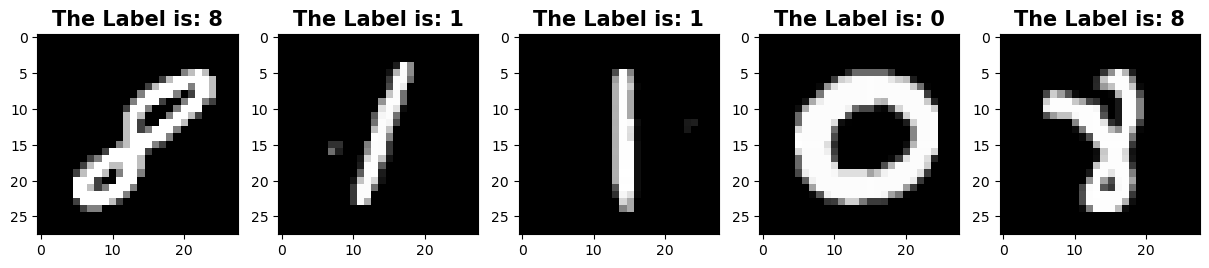

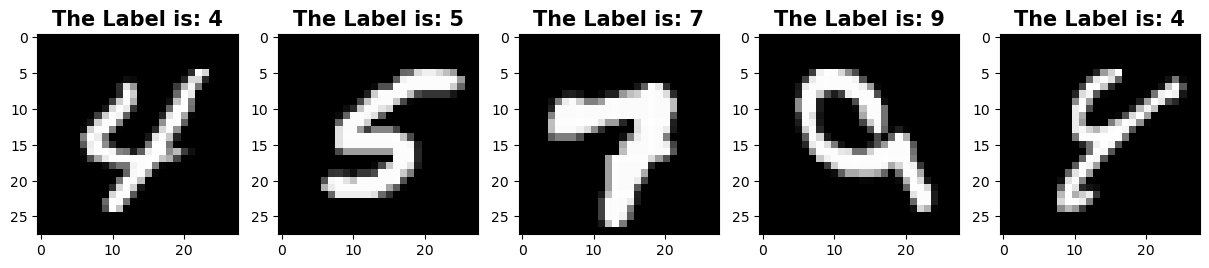

In [108]:
X = training_data.data
Y = training_data.targets
def plot_sample(X, Y, img_shape, sample_size = 10, n_rows = 2, n_columns = 5):
    if sample_size != n_rows*n_columns:
        raise Exception("the argument sample_size should equal n_rows * n_columns")
    for i in range(sample_size):
        if i%(sample_size//2) == 0:
            figure = plt.figure(figsize=(15,15))
        ax = plt.subplot(n_rows, n_columns, i+1)
        idx = torch.randint(low = 0, high =len(Y), size = (1,))
        plt.imshow(X[idx].view(*img_shape), cmap='gray')
        ax.set_title('The Label is: {}'.format(Y[idx][0]), fontsize =15, fontweight="bold")
plot_sample(X, Y,(28,28))

In [88]:
item_frequency = {}
for i in range(10):
    item_frequency[i] = (Y == i).sum().item()

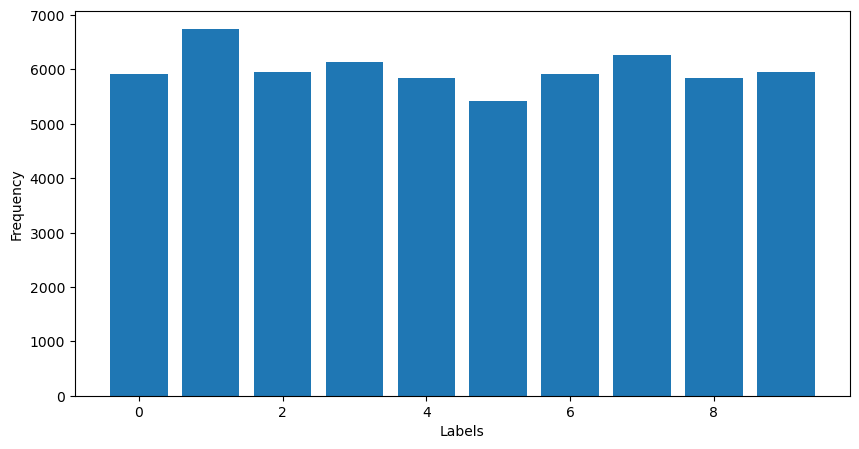

In [114]:
def plot_bar_from_dict(dictionary, x_label = None, y_label= None):
    fig = plt.figure(figsize=(10,5))
    keys = dictionary.keys()
    values = dictionary.values()
    plt.bar(keys, values)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
plot_bar_from_dict(item_frequency, "Labels", "Frequency")

In [9]:
class network(nn.Module):
    def __init__(self, inp_size, hidden_size, out_size):
        super(network, self).__init__()
        self.inp_layer = nn.Linear(inp_size, hidden_size)
        self.h_layer = nn.Linear(hidden_size, hidden_size)
        self.out_layer = nn.Linear(hidden_size, out_size)
        self.relu = nn.ReLU()
    def forward(self, x):
        out = self.inp_layer(x)
        out = self.relu(out)
        out = self.h_layer(out)
        out = self.relu(out)
        out = self.out_layer(out)
        return out

In [10]:
model = network(input_shape, hidden_size, out_size)

In [11]:
CUDA = torch.cuda.is_available()
if CUDA:
    model = model.cuda()
    
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= lr)

In [12]:
start = time.time_ns()
correct = 0
total  = 0
for epoch in range(epochs):
    for i, (batch, labels) in enumerate(train_loader):
        batch = batch.view(-1, 28*28)
        if CUDA:
            batch = batch.cuda()
            labels = labels.cuda()
        optimizer.zero_grad()
        result = model(batch)
        _, predicted = torch.max(result.data, -1)
        total += labels.size(0)
        if CUDA:
            correct += (predicted.cpu() == labels.cpu()).sum()
        else:
            correct += (predicted == labels).sum()
        loss = criterion(result, labels)
        loss.backward()
        optimizer.step()
        if (i+1) %100 == 0:
            print("Epoch {}/{}, Iteration {}/{}, Loss {}, ACC {}".format\
                  (epoch+1, epochs, i, len(training_data)//batch_size,loss.item(), 100*torch.true_divide(correct, total)))
            clear_output(wait=True)
end = time.time_ns()


Epoch 20/20, Iteration 399/468, Loss 0.03716091811656952, ACC 98.75218200683594


In [131]:
test_correct = 0
test_total = 0 
Y_prediction = torch.tensor([]).cuda()
for batch, labels in test_loader:
    batch = batch.view(-1, 28*28)
    if CUDA:
        batch = batch.cuda()
    result = model(batch)
    _, predicted = torch.max(result, -1)
    Y_prediction = torch.cat((Y_prediction, predicted))
    test_total += labels.size(0)
    loss += criterion(result.cuda(), labels.cuda())
    if CUDA:
        test_correct += (predicted.cpu() == labels.cpu()).sum()
    else:
        test_correct += (predicted == labels).sum()
print("Testing ACC {}, Loss {}".format(100 * torch.true_divide(test_correct, test_total), loss.item()/test_total))

Testing ACC 97.8499984741211, Loss 0.0035528186798095703


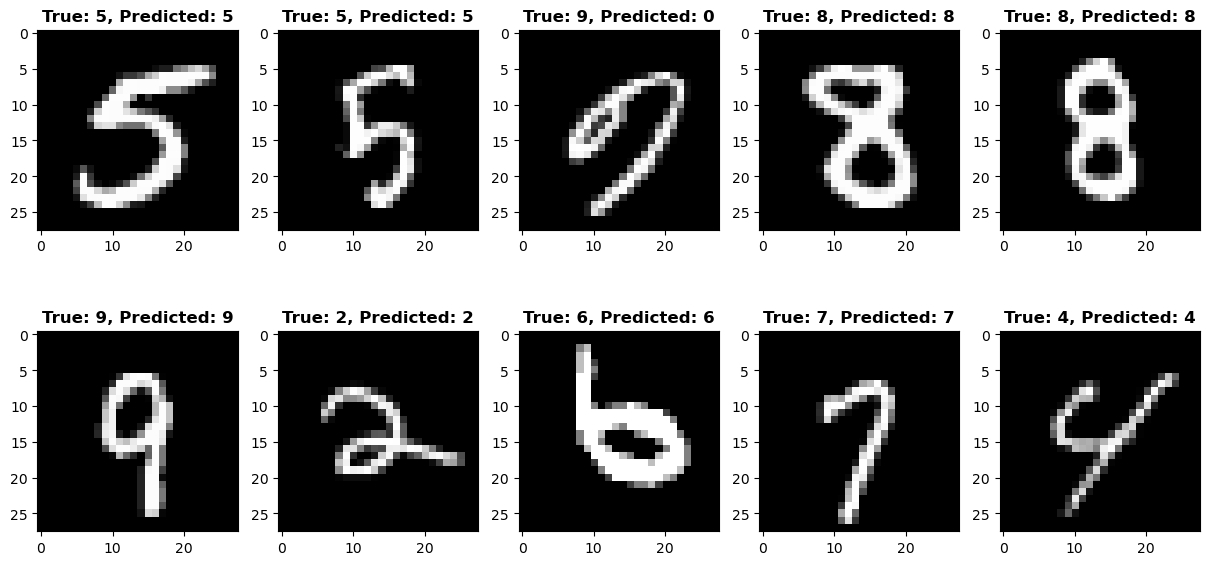

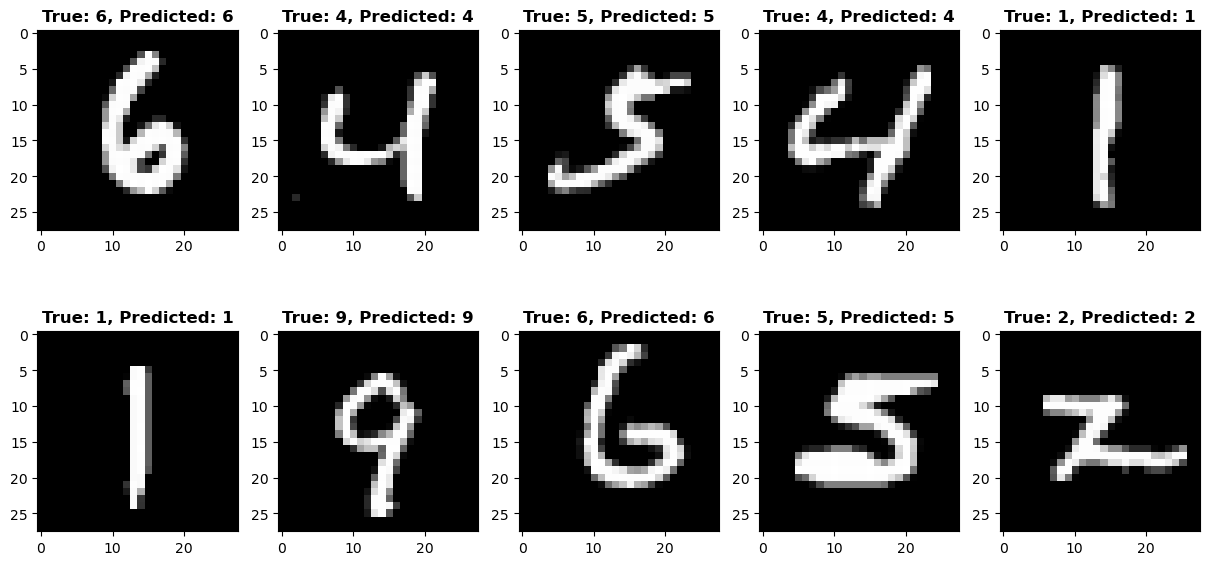

In [141]:
def plot_sample_with_labels(X, Y_true, Y_pred, img_shape, sample_size = 10, n_rows = 2, n_columns = 5):
    if sample_size != n_rows*n_columns:
        raise Exception("the argument sample_size should equal n_rows * n_columns")
    if Y_true.shape != Y_pred.shape:
        raise Exception("the shape of Y_true does not match Y_pred shape")
    for i in range(sample_size):
        if i%(sample_size//2) == 0:
            figure = plt.figure(figsize=(15,15))
        ax = plt.subplot(n_rows, n_columns, i+1)
        idx = torch.randint(low = 0, high =len(Y_true), size = (1,))
        plt.imshow(X[idx].view(*img_shape), cmap='gray')
        if Y_true[idx].item() == Y_pred[idx].int().item():
            ax.set_title('True: {}, Predicted: {}'.format(Y_true[idx].item(), Y_pred[idx].int().item()), fontsize =12, fontweight="bold")
        else:
            ax.set_title('True: {}, Predicted: {}'.format(Y_true[idx].item(), Y_pred[idx].int().item()), color="red", fontsize =12, fontweight="bold")
plot_sample_with_labels(testing_data.data, testing_data.targets, Y_prediction, (28,28), sample_size = 20, n_rows = 4)